In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../latent_analysis/'))
import LTransform as LT
from get_utils import get_hidden, get_dir, get_force
from pathlib import Path
import numpy as np
import torch as th
import plot as plot
import matplotlib.pyplot as plt

In [2]:
folder_name = 'Sim_all_inv' 
model_name = 'model00'

ff_coef = [0,8,0,-8]
phase = {'NF1':0,'FF1':8,'NF2':0,'FF2':-8}

data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)


# Apply SVD
n_muscle = 6
n_latent = 6

weight_file,_,_= get_dir(folder_name,model_name,phase[0])
W = th.load(weight_file)['fc.weight'].numpy()
print(W.shape)
U, S, Vh = np.linalg.svd(W, full_matrices=True)
V = Vh.T
P = V[:,:n_muscle] # output potent
N = V[:,n_muscle:] # output null


# Apply PCA
Data_prep =  {'x_pot_ld':[],'x_null_ld':[],'x_pot':[],'x_null':[]}
for i in range(len(phase)):
    X = data[i]
    dims = X.shape

    X_pot = X@P
    X_null = X@N

    X_pot = np.reshape(X_pot,newshape=dims[:-1]+(n_muscle,))
    X_null = np.reshape(X_null,newshape=dims[:-1]+(dims[-1]-n_muscle,))

    if i==0:
        T_p = LT.Transform(num_latent=n_latent)
        T_p.fit(X_pot,method='PCA')

        T_l = LT.Transform(num_latent=n_latent)
        T_l.fit(X_null,method='PCA')

    x_pot_ld = T_p.transform(X_pot,ensure_orthogonality=True)
    x_null_ld = T_l.transform(X_null,ensure_orthogonality=True)

    Data_prep['x_pot_ld'].append(x_pot_ld)
    Data_prep['x_null_ld'].append(x_null_ld)
    Data_prep['x_pot'].append(X_pot)
    Data_prep['x_null'].append(X_null)

KeyError: 0

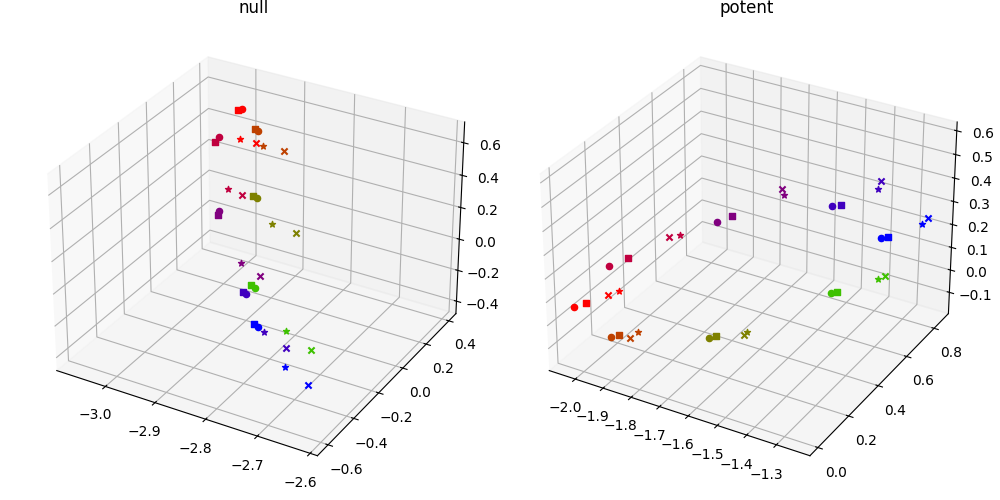

In [21]:
%matplotlib widget
#%matplotlib qt
# ['x', 'o', '*', 's']
latent = [0,1,2]
dim=3
which_times = np.arange(10)
which_times =[10]
plot_scatter=1

if dim==2:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
else:
    fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw={'projection':'3d'})

plot.plot_traj(ax[0],Data_prep['x_null_ld'],which_times=which_times,plot_scatter=plot_scatter,dim=dim,which_latent=latent)
ax[0].set_title('null')

plot.plot_traj(ax[1],Data_prep['x_pot_ld'],which_times=which_times,plot_scatter=plot_scatter,dim=dim,which_latent=latent)
ax[1].set_title('potent')

plt.tight_layout()
plt.show()

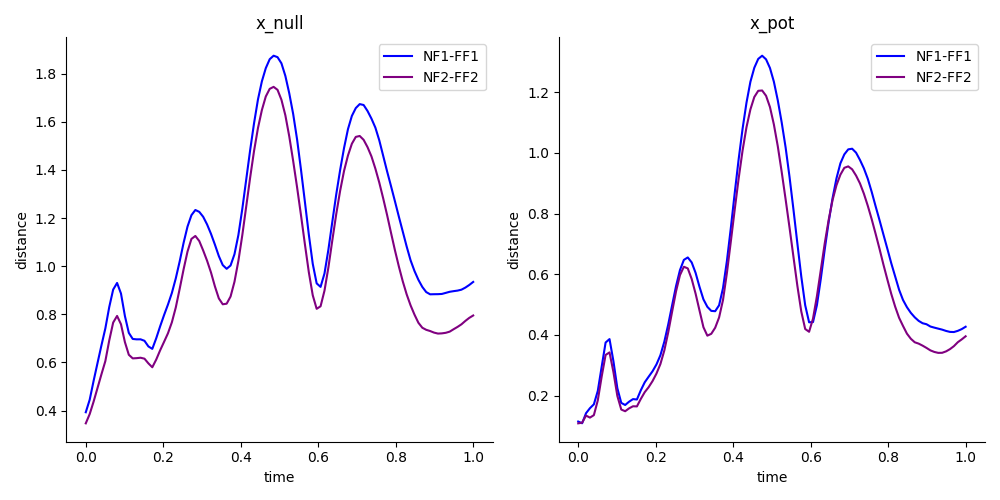

In [25]:
# 0-NF1, 1-FF1, 2-NF2, 3-FF2
# 0-(0,1) NF1-FF1 
# 1-(0,2) NF1-NF2 X
# 2-(0,3) NF1-FF2 X
# 3-(1,2) FF1-NF2 X
# 4-(1,3) FF1-FF2 X
# 5-(2,3) NF2-FF2

fig,ax = plt.subplots(1,2,figsize=(10,5))
from scipy.spatial.distance import pdist

color_list = ['blue','orange','red','green','cyan','purple']
style = ['-','-','-','-','-','-']
label = ['NF1-FF1','NF1-NF2','NF1-FF2','FF1-NF2','FF1-FF2','NF2-FF2']

for k,s in enumerate(['x_null','x_pot']):
    D = np.stack(Data_prep[s])
    dist = np.zeros((8,100,6))
    for i in range(8):
        for j in range(100):
            dist[i,j,:] = pdist(D[:,i,j,:])

    dist = np.mean(dist,axis=0)

    x = np.linspace(0,1,dist.shape[0])

    for i,d in enumerate([0,5]): # [0,5]  [1,4]
        ax[k].plot(x,dist[:,d],color=color_list[d],linestyle=style[d],label=label[d])
    ax[k].legend()
    ax[k].set_xlabel('time')
    ax[k].set_ylabel('distance')
    ax[k].spines[['top','right']].set_visible(False)
    ax[k].set_title(s)
    #ax[k].gca().spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.show()

# Project on the Force space

In [9]:
from tdr import gsog

folder_name = 'Sim_all_inv' 
model_name = 'model01'

ff_coef = [0,8,0,8,-8]
phase = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8,-8]}

N_idx = 18
F_idx = 25


data = get_hidden(folder_name,model_name,phase,ff_coef,demean=False)
force = get_force(folder_name,model_name,phase,ff_coef)

for i in range(len(data)):
    data[i] = data[i][:,N_idx,:]
    force[i] = force[i][:,F_idx,:]


combined_N = np.vstack(data)
mean_N = np.mean(combined_N, axis=0)
for i in range(len(data)):
    data[i] = data[i]-mean_N

X = force[0]
N = data[0]

behav = np.hstack((X,np.ones((X.shape[0],1))))
betaBehav2Neural = np.linalg.lstsq(behav, N, rcond=None)[0]

# Compute the TDR axes.
betaNeural2Behav = np.linalg.pinv(betaBehav2Neural)
betaNeural2Behav = betaNeural2Behav[:,:X.shape[1]]

# Orthogonalize the TDR axes before projection.
betaNeural2BehavOrth = gsog(betaNeural2Behav)

# Project before-learning and after-learning neural activity onto the TDR axes
data_p = data.copy()
for i in range(len(data)):
    data_p[i] = data_p[i] @ betaNeural2BehavOrth[0]

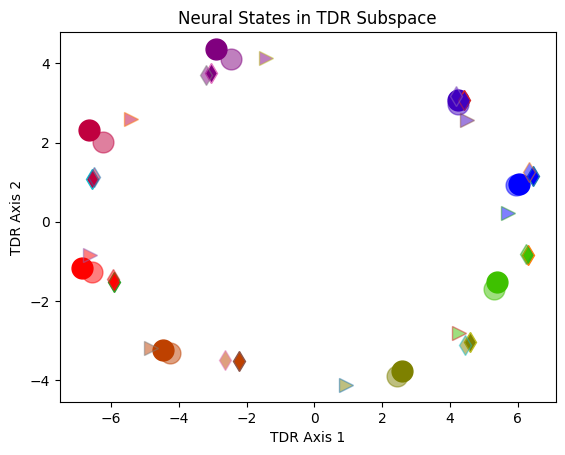

In [12]:
angle_set = np.deg2rad(np.arange(0, 360, 45))  # 8 directions
#angle_set = np.deg2rad(np.array([0,45,60,75,90,105,120,135,180,225,315]))
color_list = [plt.cm.brg(cond / (2 * np.pi)) for cond in angle_set]
n_cond = len(angle_set)

# Create a scatter plot
plt.figure()
for i in range(n_cond):
    plt.plot(data_p[0][i,0], data_p[0][i,1],'.', markersize=30, color=color_list[i])
    plt.plot(data_p[1][i,0], data_p[1][i,1],'d', markersize=10, markerfacecolor=color_list[i])
    plt.plot(data_p[2][i,0], data_p[2][i,1],'.', markersize=30, color=color_list[i],alpha=0.5)
    plt.plot(data_p[3][i,0], data_p[3][i,1],'d', markersize=10, markerfacecolor=color_list[i],alpha=0.5)
    plt.plot(data_p[4][i,0], data_p[4][i,1],'>', markersize=10, markerfacecolor=color_list[i],alpha=0.5)

plt.xlabel('TDR Axis 1')
plt.ylabel('TDR Axis 2')
plt.title('Neural States in TDR Subspace')

plt.show()